# Machine Learning Sample for Milestone 4: Dimensionality Reduction and Clustering with t-Distributed Stochastic Neighbor Embedding and the K-Nearest Neighbors Algorithm
### Warning: On Colab, this notebook takes about 25 minutes to run in full! It will likely run much faster on your local machine, but there are also modifications noted in comments that can speed up the cells that take a while to run.
In our application, we plan to have a component where a user can note that they liked a particular recipe, and the back-end will respond with recommendations for similar recipes. This notebook will explain how I implemented t-Distributed Stochastic Neighbor Embedding (t-SNE) and k-Nearest Neighbors (k-NN) to provide recipe recommendations for the platform.

For the purpose of recommendations, we define a "similar recipe" as a recipe containing similar ingredients in similar quantities to the liked recipe. Here is a short description of how I structured the data for this goal: First, every unique ingredient that appears in any recipe is a feature for the model (meaning, for the data in the `json` file I use here, there are over 4,000 features). Every data point is a recipe, where the values are just the amount of each ingredient used in the recipe, and every unused ingredient is assigned a quantity of 0. Every recipe, then, is essentially a point in a 4,000+ dimensional space, where every dimension is an ingredient.

For the sake of simplicity, I've ignored units, "trusting" that the same ingredient, across a multitude of recipes, is likely to be represented with the same unit. Down the line, though, we could enforce a standard (probably grams) for everything, although it may be difficult to convert between volumetric and by-weight units without extra data about ingredient weight. We also tried scaling the data as a preprocessing step and, separately, using 1/0 for whether a recipe contained an ingredient (instead of a quantity), but both gave worse recommendations. Those results are also included.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.width', 100)

## Loading the Dataset
For this sample, I used an existing `json` with around 18,000 recipes, simply because we haven't web scraped at this scale yet. The `json` data is in a similar format to how we store the data that we do have, so we'll only need to make slight alterations when merging this data with our own and pushing everything to the database. Then, when training our model, we can just pull everything from the database in a similar format so everything works with minimal alteration to the code.

In [2]:
recipe_url = "https://raw.githubusercontent.com/kbrohkahn/recipe-parser/master/recipes.json"
recipe_df = pd.read_json(recipe_url, lines=True) \
    .drop_duplicates(subset=['name']) \
    .reset_index(drop=True)
recipe_df.head()

,id,name,ingredients,calories,servings,directions,footnotes,labels
0,6663,Crispy Cheese Twists,"[{'labels': ['dairy', 'cheese'], 'ingredient':...",121,0,"[{'direction': 'Combine parmesan cheese, peppe...",[],"[cheese, dairy, dessert]"
1,6664,"Basil, Roasted Peppers and Monterey Jack Cornb...","[{'labels': ['cooking fat'], 'ingredient': 'un...",314,0,[{'direction': 'Preheat oven to 400 degrees F ...,[],"[vegetable, bread]"
2,6665,Mom's Yeast Rolls,"[{'labels': ['cooking liquid'], 'ingredient': ...",104,0,"[{'direction': 'Melt margarine in hot water.',...",[],"[baking ingredient, bread]"
3,6666,Sweet Potato Bread I,"[{'labels': ['sugar'], 'ingredient': 'white su...",303,0,[{'direction': 'Combine sugar and oil; beat we...,[],"[vegetable, bread]"
4,6667,Cornish Splits,"[{'labels': ['baking ingredient'], 'ingredient...",198,0,"[{'direction': 'In a small bowl, dissolve the ...",[],[dessert]


## Preparing the Data
In order to prepare the data, I used the `set` data structure to build a collection of all unique ingredient names to serve as columns in our ingredient `DataFrame`. Then, I iterated through the recipe `DataFrame` and counted up all of the ingredient quantities used in every recipe and loaded them into the ingredient `DataFrame`. Finally, I converted this `DataFrame` to an `np.ndarray`, which would serve as our input vector. We also applied some modifications (scaling and converting to binary, separately, as mentioned before) for other tests.

In [3]:
"""
CHATGPT QUERY USED:
i'm working with a pandas dataframe containing a lot of recipes. there's a row "ingredients" 
that contains a list of dictionaries containing ingredient names and amounts. 
i want to preprocess this data for machine learning such that there are distinct columns for every
ingredient, where the value is the amount used in the recipe (for nearest neighbor classification).
how would i process this data?
"""

ingredients = set()
for recipe in recipe_df['ingredients']:
    for ingredient in recipe:
        ingredients.add(ingredient['ingredient'].lower())
ingredient_df = pd.DataFrame(np.zeros((recipe_df['name'].shape[0], len(ingredients))))
ingredient_df.columns = list(ingredients)
index = 0

for i, recipe in enumerate(recipe_df['ingredients']):
    recipe_dict = {ingredient['ingredient'].lower(): ingredient['amount'] for ingredient in recipe}
    ingredient_df.loc[i] = pd.Series(recipe_dict, dtype='float64')
ingredient_df = ingredient_df.fillna(0)
ingredient_df.head()

,granulated garlic,crescent rolls,onion powder or to taste,baking powder,gluten free casein free margarine,sweet apples,rye bread,peach juice,malted milk powder,pretzel sticks,...,beef top sirloin steaks,boneless beef short ribs,baby lima beans,betty crocker ® rich & creamy chocolate ready to spread frosting,yellow beans,round pumpernickel loaves,unpeeled apples,jerusalem artichokes,taster's choice® 100% pure instant coffee,sea bass
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = ingredient_df.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_binary = X.copy().astype(bool).astype(int)
print(X.shape)

(17777, 4425)


## A Quick Aside About Algorithms
Before we use t-SNE and k-NN, let's first discuss a little about why I chose them specifically.
#### Why k-NN?
It was an easy decision to use some form of clustering for this problem: this was an unsupervised learning problem, and my goal was to find recipes that were similar to others. I decided against k-Means clustering since I didn't have a set number of clusters in mind. In fact, I wasn't sure how well the data would cluster (or if it would form tight clusters at all). In the graph visualizations below of the recipe space, you will notice that the data is generally organized in one large blob, with a few clusters around the edges for some of the more niche, interrelated recipes (like those for specific types of alcoholic beverages, for example). When using k-NN, this lack of clear clustering didn't inhibit the quality of the recommendations, which now depended more on how densely packed the recipes were rather than whether or not they were split into groups (because the nearest neighbors are independent of the context of the rest of the space). That is, as long as there were recipes close to any particular recipe, the recommendations would still be good, even if they weren't all packed in their own neat cluster (in fact, it was probably better without tight clusters, as will be explained later!). For these reasons, the k-Nearest Neighbors algorithm seemed like a good choice.

#### Why t-SNE?
At first, when using k-NN to find recipes that were close to each other in the 4,000+ dimensional recipe space, but I found that there were lots of erratic recommendations intermixed with the good ones. I eventually decided that k-NN was overfitting the data, suffering from the curse of dimensionality. For this reason, I wanted to try using a dimensionality reduction algorithm as a preprocessing step. My first choices were t-SNE and Principal Component Analysis (PCA). I eventually decided on t-SNE, which excels at preserving the information that the high number of features provide (which would be useful for relating recipes that use niche ingredients), rather than attempting to isolate important ones. It also excelled at pushing related points closer together (whose relationships weren't as easy to see in the high-dimensional space), which significantly improved the consistency and quality of recommendations. Finally, because t-SNE visualizes data well, I was able to plot the data, as is shown below.

## Hyperparameter Tuning
I needed to tune the learning rate, perplexity, and number of iterations for t-SNE. We tried many different values and evaluted the final data in two different ways: first, I visually inspected the `pyplots` and made sure there weren't any obvious inconsistencies. Next, I used Silhouette score to quantitatively analyze the hyperparameters. Crucially, although the Silhouette scores were relatively low (all in the range of -0.15 to -0.5, on a -1 to 1 scale), which indicated poor clustering of the data, the scores were close enough to 0 to indicate that the data was relatively free of misclassifications. To our surprise, the recipe space seemed rather uniform (not too many natural clusters formed), which ended up working to our advantage. Again, more on that later.

In [5]:
def test_hyper(X_trial, k, parameters):
    tsne_try = TSNE(**parameters)
    fit = tsne_try.fit_transform(X_trial)
    plt.scatter(fit[:, 0], fit[:, 1])
    plt.title(f"Hyperparameters: Perplexity: {parameters['perplexity']}, Learning Rate: {parameters['learning_rate']}, Number of Iterations: {parameters['n_iter']}")
    plt.show()
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(fit)
    distances, indices = knn.kneighbors(fit)
    silhouette_scr = silhouette_score(X_trial, indices[:, 1])
    return silhouette_scr

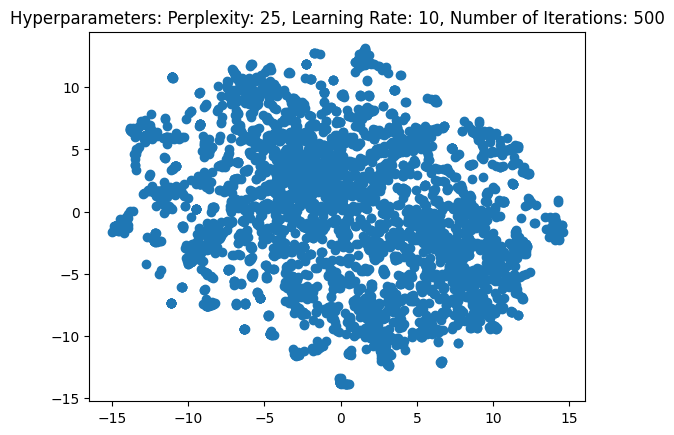

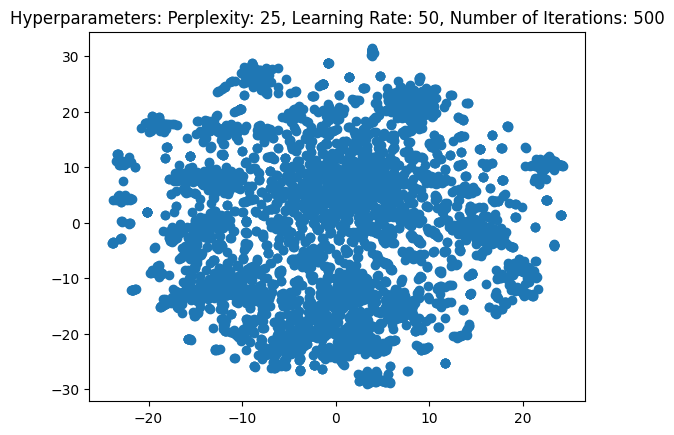

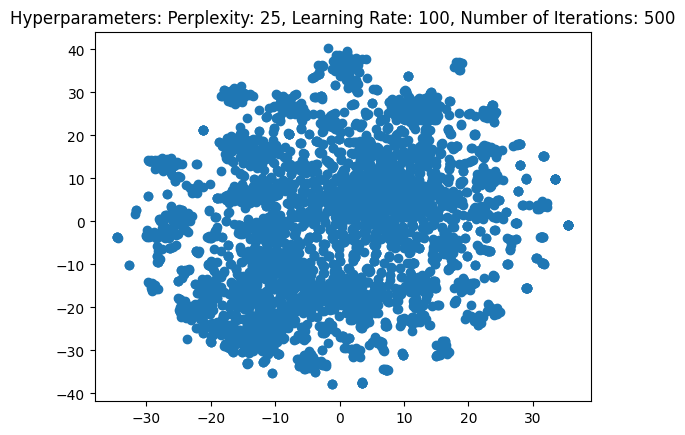

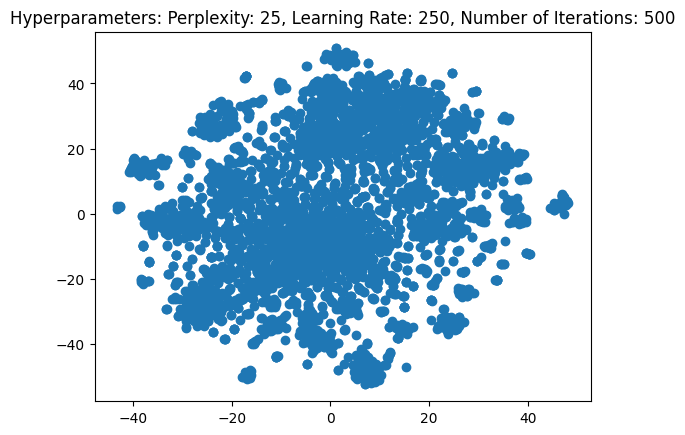

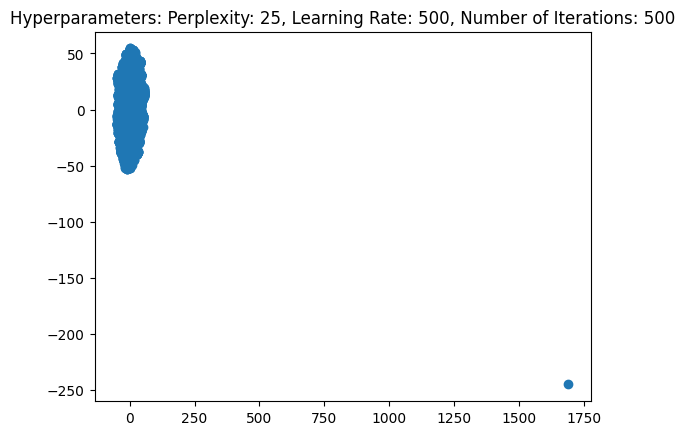

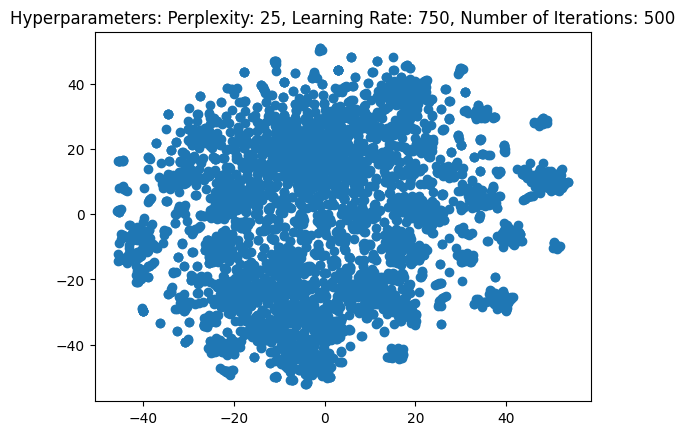

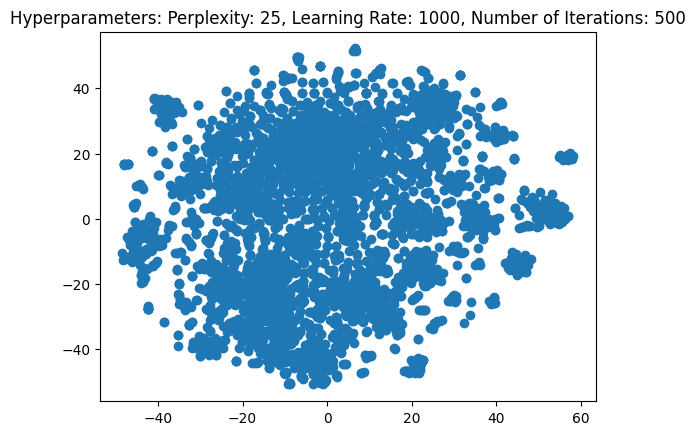

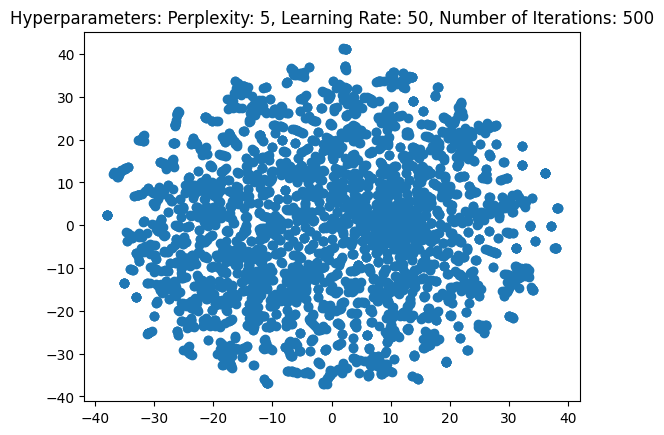

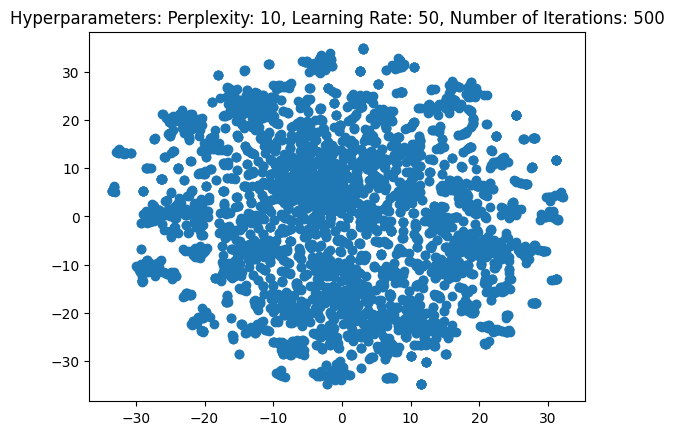

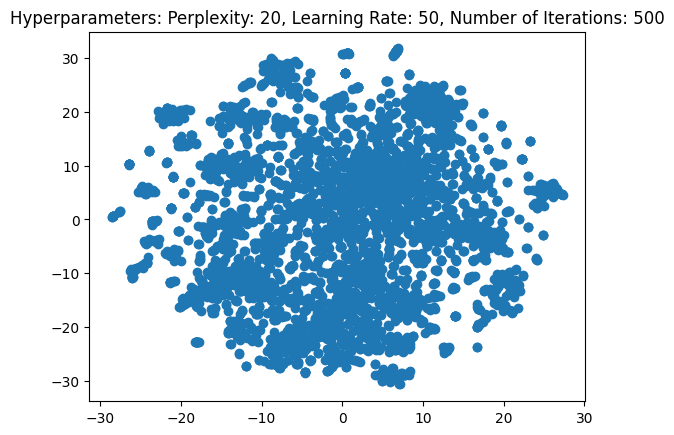

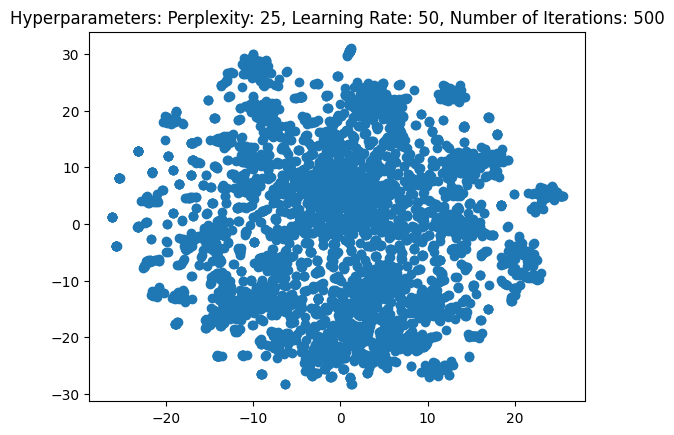

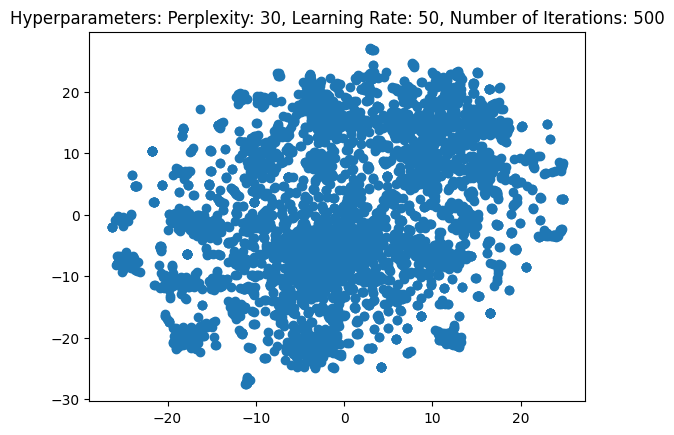

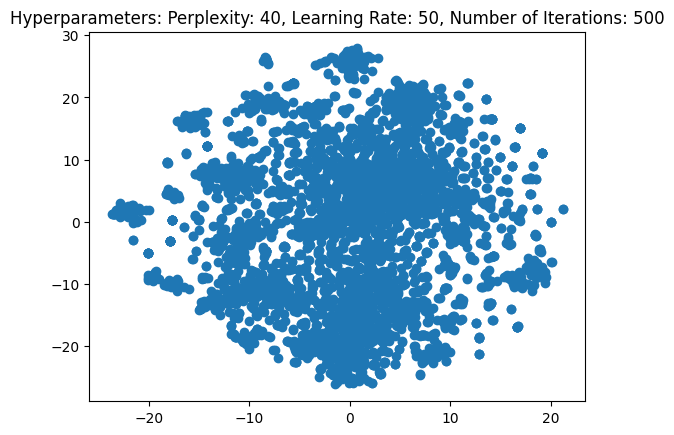

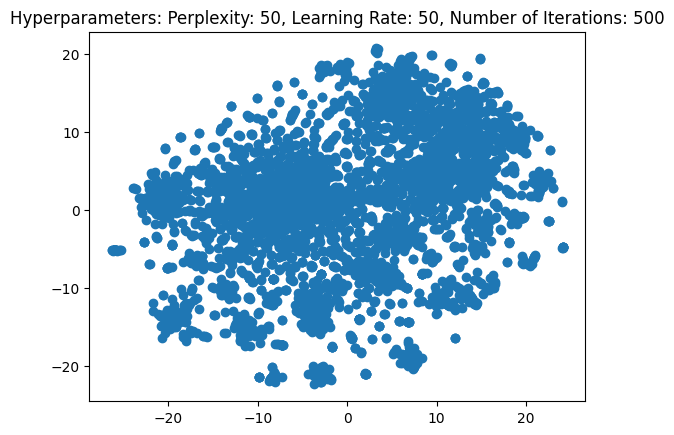

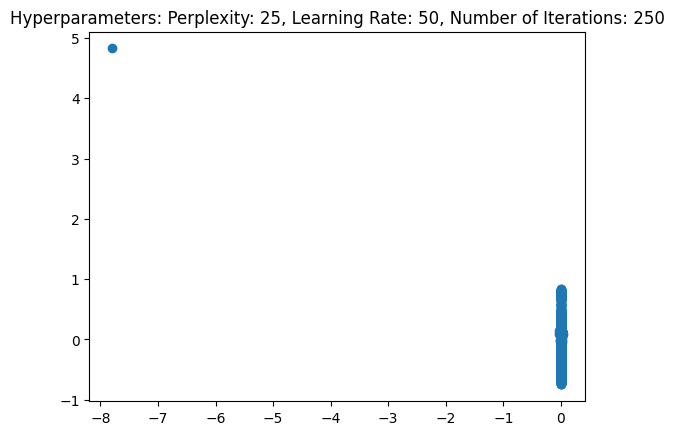

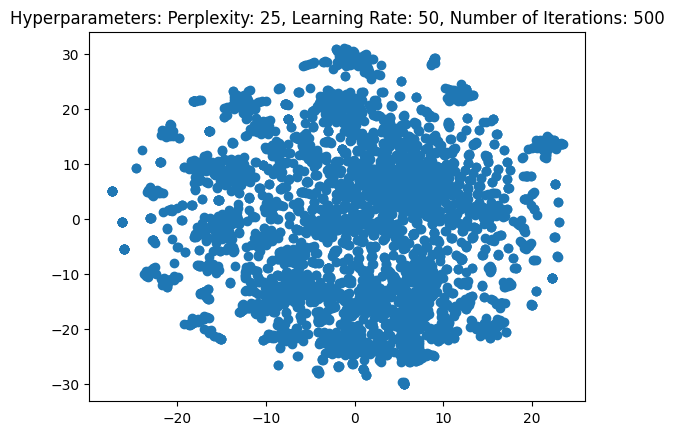

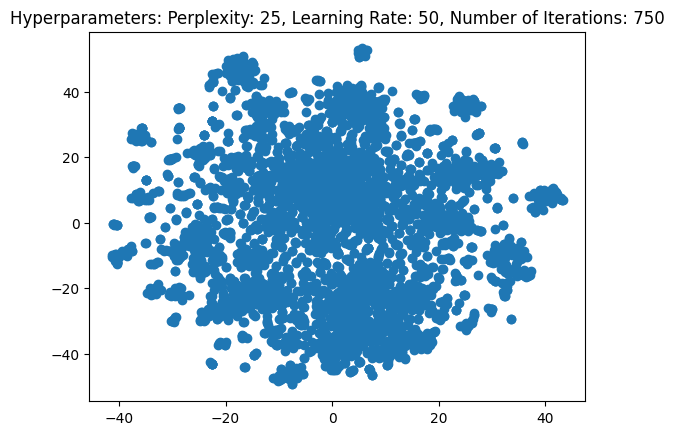

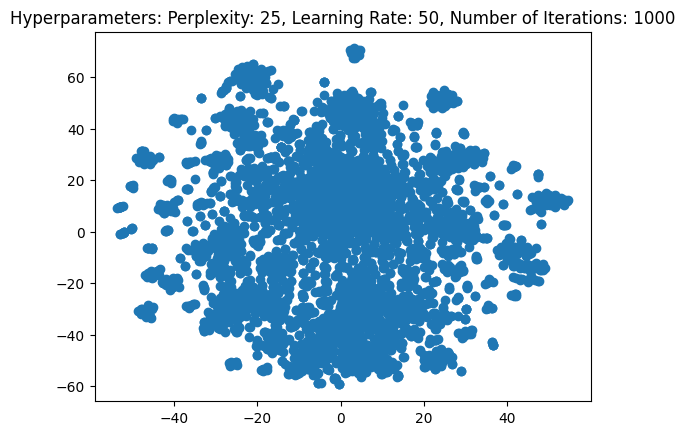

In [6]:
'''
Warning, this cell takes about 11 minutes to run on Colab! If you are strapped
for time, you can just scroll past this section, set the hyperparameters to the
following, manually, and then train the model.
Learning Rate: 100
Perplexity: 5
Iterations: 750
'''

# Tuning learning rate.
subset_trials, ignore = train_test_split(X, test_size=0.75, random_state=42)
learning_rates = [10, 50, 100, 250, 500, 750, 1000]
silhouette_scores_rate = []
for idx, rate in enumerate(learning_rates):
    silhouette = test_hyper(subset_trials, 10, {'perplexity': 25, 'learning_rate': rate,  'n_iter': 500})
    silhouette_scores_rate.append(silhouette)

# Tuning perplexity.
perplexities = [5, 10, 20, 25, 30, 40, 50]
silhouette_scores_perp = []
for idx, plex in enumerate(perplexities):
    silhouette = test_hyper(subset_trials, 10, {'perplexity': plex, 'learning_rate': 50, 'n_iter': 500})
    silhouette_scores_perp.append(silhouette)

# Tuning number of iterations.
iters = [250, 500, 750, 1000]
silhouette_scores_iters = []
for idx, iter in enumerate(iters):
    silhouette = test_hyper(subset_trials, 10, {'perplexity': 25, 'learning_rate': 50,  'n_iter': iter})
    silhouette_scores_iters.append(silhouette)

Learning Rate: 10	Silhouette: -0.12746201969954946
Learning Rate: 50	Silhouette: -0.1109273903379176
Learning Rate: 100	Silhouette: -0.10639123009094346
Learning Rate: 250	Silhouette: -0.10834637783048685
Learning Rate: 500	Silhouette: -0.1110224996922934
Learning Rate: 750	Silhouette: -0.11012642149940545
Learning Rate: 1000	Silhouette: -0.11195656342077014


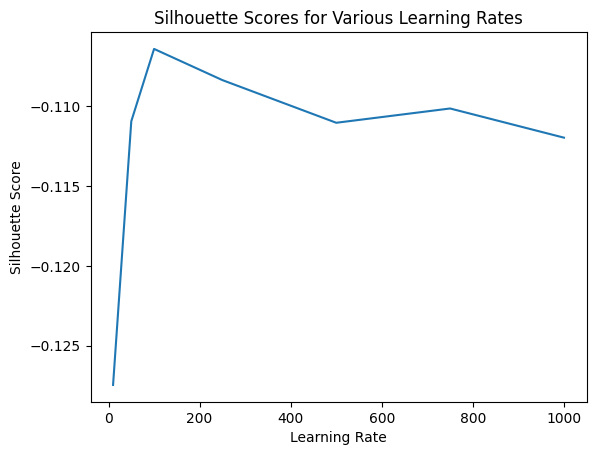

Perplexity: 5	Silhouette: -0.10321639958724826
Perplexity: 10	Silhouette: -0.1089230183499222
Perplexity: 20	Silhouette: -0.11428035985029035
Perplexity: 25	Silhouette: -0.11134158572764151
Perplexity: 30	Silhouette: -0.1165720192277539
Perplexity: 40	Silhouette: -0.11559522408230856
Perplexity: 50	Silhouette: -0.1189752976543994


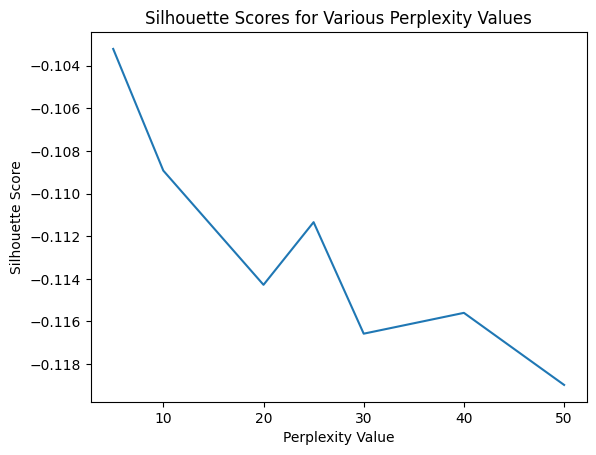

Number of Iterations: 250	Silhouette: -0.23745416165980776
Number of Iterations: 500	Silhouette: -0.1116030069050807
Number of Iterations: 750	Silhouette: -0.10743276550569675
Number of Iterations: 1000	Silhouette: -0.10958320577272802


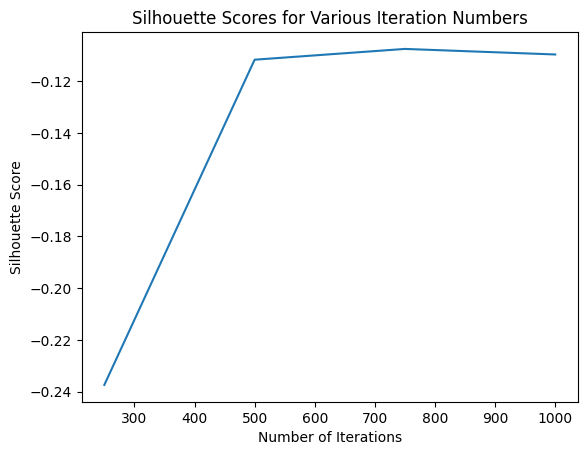

In [7]:
for idx, rate in enumerate(learning_rates):
    print(f"Learning Rate: {rate}\tSilhouette: {silhouette_scores_rate[idx]}")
plt.plot(learning_rates, silhouette_scores_rate)
plt.xlabel("Learning Rate")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Various Learning Rates")
plt.show()

for idx, plex in enumerate(perplexities):
    print(f"Perplexity: {plex}\tSilhouette: {silhouette_scores_perp[idx]}")
plt.plot(perplexities, silhouette_scores_perp)
plt.xlabel("Perplexity Value")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Various Perplexity Values")
plt.show()

for idx, iter in enumerate(iters):
    print(f"Number of Iterations: {iter}\tSilhouette: {silhouette_scores_iters[idx]}")
plt.plot(iters, silhouette_scores_iters)
plt.xlabel("Number of Iterations")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Various Iteration Numbers")
plt.show()

In [8]:
best_rate_ind = silhouette_scores_rate.index(max(silhouette_scores_rate))
best_perplexity_ind = silhouette_scores_perp.index(max(silhouette_scores_perp))
best_iters_ind = silhouette_scores_iters.index(max(silhouette_scores_iters))
print(f'Best Hyperparameter Values:')
print(f'\tLearning Rate: {learning_rates[best_rate_ind]}\t' +
      f'Silhouette Score: {silhouette_scores_rate[best_rate_ind]}')
print(f'\tPerplexity: {perplexities[best_perplexity_ind]}\t\t' +
      f'Silhouette Score: {silhouette_scores_perp[best_perplexity_ind]}')
print(f'\tIterations: {iters[best_iters_ind]}\t\t' +
      f'Silhouette Score: {silhouette_scores_iters[best_iters_ind]}')
best_hyperparameters = {
    'learning_rate': learning_rates[best_rate_ind],
    'perplexity': perplexities[best_perplexity_ind],
    'n_iter': iters[best_iters_ind]
}

Best Hyperparameter Values:
	Learning Rate: 100	Silhouette Score: -0.10639123009094346
	Perplexity: 5		Silhouette Score: -0.10321639958724826
	Iterations: 750		Silhouette Score: -0.10743276550569675


## Training the Model
Finally, it was time to train the model. I used our tuned hyperparameters for t-SNE and chose 10 for the number of nearest neighbors (a good balance between providing lots of recommendations but not using too much storage, because these will eventually be stored in the database). I grabbed the output indices and mapped their corresponding recipe names to a `DataFrame` called `neighbors_df`.

In [9]:
# Train the model and return the outputs
def get_neighbor_lists(X, hyperparameters, k):
    tsne = TSNE(**hyperparameters)
    X_transform = tsne.fit_transform(X)
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_transform)
    distances, indices = knn.kneighbors(X_transform)
    neighbor_indices = indices[:, 1:]
    neighbor_distances = distances[:, 1:]
    recipe_names = recipe_df['name']
    neighbors_df = pd.DataFrame({'Recipe': recipe_names})
    for i in range(k - 1):
        neighbors_df[f'KNN {i+1}'] = np.array(recipe_names)[neighbor_indices[:, i]]
    return neighbor_distances, neighbor_indices, neighbors_df, X_transform

In [10]:
'''
Since three models are being trained here, this cell takes about 12 minutes to
run in Colab. If you would like, you can just only train the last model,
which is the best. Doing that will require you to also comment out a few lines
displaying information about the other models.
'''

k = 10
hyperparameters = best_hyperparameters
neighbor_distances_scaled, neighbor_indices_scaled, neighbors_df_scaled, X_transform_scaled = \
    get_neighbor_lists(X_scaled, hyperparameters, k)
neighbor_distances_binary, neighbor_indices_binary, neighbors_df_binary, X_transform_binary = \
    get_neighbor_lists(X_binary, hyperparameters, k)
neighbor_distances, neighbor_indices, neighbors_df, X_transform = \
    get_neighbor_lists(X, hyperparameters, k)

## Analyzing the Models
In order to gauge the general quality/confidence of one recommendation when compared to the model's other recommendations, we can look at the average distances between the recipes and their 10 nearest neighbors. Instead of picking a random recipe, we can look at the median of these average distances to try to gauge the average case of a recommendation. Below, you can see a small range around the medians to understand how each model performs. 

I additionally took a look at the worst case and gained some interesting intuition: for some/most of the worst cases, the nearest neighbor is actually a strong recommendation, but the other neighbors are significantly worse. What's more, there is lots of overlap between these lower-ranking recipes (that is, they're likely in each other's recommendation lists). This implies that these worst cases are likely sparse clusters straggling outside of the central mass. However, it's interesting to note that almost no recipe straggles alone—there's almost always at least one good recommendation. The 5 worst cases for each model are also below.

The best case did not offer much insight—the higher-ranking recommendations were always just repeatedly different orderings of one extremely dense cluster, which was difficult to place in context of the rest of the data points. This is a good thing, though! It's great that dense clusters seem to provide much less interesting recommendations, because this means that our model's general lack of tight clusters will make for better recommendations!

Finally, you can notice that the Silhouette scores here are much closer to zero than they were for the training sets, likely as a result of the larger number of data points, which, thankfully, creates an even more uniform recipe space (instead of creating more clusters, even though there are likely more hidden trends in the data now).

Overall, I felt the best model was made from the unscaled data, but the scaled data performed somewhat similarly (its Silhouette score could even be better sometimes, depending on how t-SNE placed the data, but the actual recommendations were pretty much always worse because of how prone it was to overfitting), and the binary data also wasn't too far behind (but was also prone to overfitting).

In [11]:
"""
CHATGPT QUERY:
provide code to return, in two separate variables, the indices of the n largest and n smallest elements in an array, sorted by the values in the array
"""
# Print a nicely formatted analysis of useful metrics for the data
def print_neighbor_metrics(neighbor_distances, neighbors_df, range, case_name):
    avg_distances = np.mean(neighbor_distances, axis=1)
    sorted_avg_indices = np.argsort(avg_distances)
    median = sorted_avg_indices.shape[0] // 2
    largest_avg_indices = sorted_avg_indices[-range:]
    median_avg_indices = sorted_avg_indices[median - range : median + range]
    pretty_print_titled_df(neighbors_df.loc[largest_avg_indices], f"{range} Worst Cases for Average Distances to Closest Neighbors for {case_name}")
    pretty_print_titled_df(neighbors_df.loc[median_avg_indices], f"{range * 2 + 1} Medians for Average Distances to Closest Neighbors for {case_name}")

# Helper to format dataframes with a title
def pretty_print_titled_df(df, title, max_rows=10, max_colwidth=20):
    titled_df_html = df \
        .style \
        .set_caption(f"<h1 style='text-align: center'>{title}</h1>") \
        .to_html( \
            max_rows=max_rows, \
            max_colwidth=max_colwidth, \
            escape=False, \
            table_attributes='style="width:100%;"' \
        )
    display(HTML(titled_df_html))

In [12]:
print_neighbor_metrics(neighbor_distances_scaled, neighbors_df_scaled, 5, "Scaled Data")
print_neighbor_metrics(neighbor_distances_binary, neighbors_df_binary, 5, "Binary Data")
print_neighbor_metrics(neighbor_distances, neighbors_df, 5, "Unscaled Data")

,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
2171,Chicken 'n' Stuff,One Dish Chicken Bake,Thanksgiving Meatloaf,Stuffed Mushrooms II,Sour Cream Refrigerator Mashed Potatoes,Mom's Cheese Ball,Broccoli Cheese Layer Bake,Macaroni And Cheese II,Cheesy Vegetable Soup II,Slow Cooker Dump and Go Cheesy Chicken
921,Toffee Bar Coffee Cake,Toffee Bar Cheesecake,Death By Chocolate IV,Death by Chocolate,Lemonade Cake III,Lemon Lu Lu Cake,Lemon Bundt Cake,Quick Lemon Poppy Seed Bread,Luscious Lemon Cake,Lemon Pound Cake II
11633,Death by Chocolate,Toffee Bar Coffee Cake,Toffee Bar Cheesecake,Death By Chocolate IV,Lemonade Cake III,Lemon Lu Lu Cake,Lemon Bundt Cake,Quick Lemon Poppy Seed Bread,Luscious Lemon Cake,Lemon Pound Cake II
10798,Toffee Bar Cheesecake,Toffee Bar Coffee Cake,Death By Chocolate IV,Death by Chocolate,Lemonade Cake III,Lemon Lu Lu Cake,Lemon Bundt Cake,Quick Lemon Poppy Seed Bread,Luscious Lemon Cake,Lemon Pound Cake II
10353,Death By Chocolate IV,Toffee Bar Cheesecake,Toffee Bar Coffee Cake,Death by Chocolate,Lemonade Cake III,Lemon Lu Lu Cake,Lemon Bundt Cake,Quick Lemon Poppy Seed Bread,Luscious Lemon Cake,Lemon Pound Cake II


,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
10121,Pig Picking Cake II,Pig Pickin' Cake,Momma Lamb's Famous Fruit Salad,Million Dollar Cake,Pig Picking Cake III,Mandarin Orange Cake II,Fresh Cranberry Relish,Mandarin Almond Salad,Fruit Salad,Tossed Romaine and Orange Salad
11513,Killer Potato Casserole,Baked Cheese Sticks,Christmas Cornflake Wreath Cookies,Holly Christmas Cookies,Cornflake Macaroons,Holiday Wreaths,Mock Peanut Brittle,Peanut Butter Cornflake Crunch Bars,Peanut Butter Bars VI,Dishpan Cookies I
11899,Deb's Mac Salad,Macaroni Salad Virginia Style,Macaroni And Cheese I,Baked Macaroni and Cheese,Tommy's Ham Casserole,Simple Mac and Cheese,Baked Macaroni,Classic Macaroni and Cheese,My Own Macaroni and Cheese,Lori's Beef and Spaghetti Macaroni
9804,Chicken Kisses,Lemon Barbeque Pork Chops,Faye's Pulled Barbecue Pork,Baked Bar-be-Que Chicken,Busy Day Chicken,Barbecue Tofu Sandwiches,Saucy Cajun Chicken Breasts,Slow Cooker BBQ Pork Chops,Barbecued Meatballs,Smoky Mountain Chicken
5050,Bow-Tie Pasta With Red Pepper Sauce,Fried Farfalle Chips,Sausage Soup,Tuna Mushroom Casserole,Chile Pasta Salad,Turkey Goulash,Awesome Bow Tie Pasta,Sun-Dried Tomato and Bow Tie Pasta,Sesame Pasta Chicken Salad,My Own Mickmack
10735,Dill Dip II,Saint Paddy's Dill Dip,Uncle Bill's Sweet and Sour Sauce,Bagel Dip,Easy Baked Chicken Wings,Beef Summer Sausage,Cheese Ball II,Rib Rub,Dried Beef Cheese Ball,Cornish Finnish Michigan Pasties
12672,Pumpkin Spice,Nice Spice Cookies,Barbequed Pineapple,Really Nice Spice Cookies,Friendship Tea,Mostaccioli for Basilica,Peanut Butter Molasses Cookies,Syrian Spaghetti,Sour Cream Spritz,Fork Cookies
13434,Carrots Au Gratin,Creamy Vegetable Chowder,Bay Scallop Chowder,Ginny's Cheezy Macaroni,Christmas Onion Soup,Tomato Macaroni Soup,Sausage Gravy III,Cream of Fresh Tomato Soup,Winter Solstice Soup,Plum Pudding Sauce
10881,A Marinade To Die For,Sour Cream Dressing,Midwestern House Salad Dressing,Spinach Salad with Curry Vinaigrette,Glazed Pearl Onions with Raisins and Almonds,Glazed Pearl Onions With Raisins And Almonds,Caesar Salad I,Mushroom and Swiss Chicken,Zinfandel Salad Or Slaw Dressing,Beezie's Black Bean Soup
2996,Hazelnut and Almond Cookies,Bruti Ma Buoni,Heavenly Chipped Chocolate and Hazelnut Cheesecake,Chocolate Hazelnut Cake,Cinnamon Hazelnut Biscotti,Norwegian Hazelnut Cake,Chocolate Pizzelles,Russian Tea Biscuits,Chocolate Nut Biscotti,Jacinto's


,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
5015,Greek Spaghetti I,Fish in Foil,Confetti Corn,Convenient Vegetarian Lasagna,Moutabel,Killer Potato Casserole,Risotto with Sun-Dried Tomatoes and Mozzarella,Brenda's Pepperoni Chicken Rollups,Suz's Vegetable Manicotti,Roast Beef and Cheese Roll Ups
5439,Magic Lemon Pie,Chocolate Cake IV,Marble Nut Clusters,No Bake Cookies VII,One-Two-Three Cake,Pina Colada Cake III,Orange Sunshine Cake,Quick Sunshine Cake,Mandarin Orange Cake I,Pig Pickin' Cake
14873,Chocolate Cake IV,Marble Nut Clusters,Magic Lemon Pie,Soda Pop Cake,Dream Pie,One-Two-Three Cake,Pina Colada Cake III,Orange Sunshine Cake,Quick Sunshine Cake,Mandarin Orange Cake I
2108,Quick Chicken Marsala,Arlene's Bacon & Crabmeat,Pickle Rollups,Maryellen's Baked Onions,Quick and Easy Crab Rangoon Dip,Crab Rangoon I,Crab Rangoon III,Crab Puffs,Sharp Cheddar Dip,Crab Rangoon II
14644,Asian Turkey Barbecue on Sesame Scallion Toasts,Mushroom Salad II,Maryellen's Baked Onions,Stuffed Halibut,Layered Seafood Dip,Shrimp Surprise Spread,Absolutely the Best Nacho Dip Ever,Shrimp Spread I,Quick Chicken Marsala,Arlene's Bacon & Crabmeat


,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
12654,Cheesy Corned Beef Hash Casserole,Ultimate Pasta,Leftover Special Casserole,Easy Ham and Noodles,One Pot Tuna Casserole,Tuna Cheese Mac,Polish Reuben Casserole,Reuben Hot Dish,Cream Cheese Ranch Potatoes,Pasties I
16482,"The Easiest, Yummiest Sugar Cookies EVER!!!",Apple Butter Bars,Neecie's PBJ Bars,Brown Sugar Pie II,Chocolate Frosted Marshmallow Cookies,Chocolate Drop Cookies I,Frosted Maple Cookies,Dr. Pepper Cake,Snappy Turtle Cookies,Fabulous Fudge Chocolate Cake
13024,Doctor Bird Cake,Banana Raisin Cake,The Cake That Doesn't Last,Hawaiian Banana Nut Bread,Dr. Bird Cake,Hummingbird Cake I,It Won't Last Cake,Fruity Bundt Cake,Hummingbird Cake IV,Snow on the Mountain I
16297,Chewy Chocolate Candies,Chocolate Chip Pie II,French Silk Frosting,Fudge Frosting,Caroline's Chocolate Fudge Frosting,Chocolate Covered Cherry Cookie Frosting,Chocolate Butter-Creme Frosting,Fluffy Buttercream Frosting,Mint Buttercream Frosting With Dark Chocolate Glaze,Busy Day Cocoa Icing
12272,Claremont Salad,Vinegar Pickled Carrots,Hot German Potato Salad III,Irish Lamb Stew,Fabulous Hot Five Bean Salad,Sweet Pasta Salad,Hot Bacon Dressing,Restaurant-Style Coleslaw I,White BBQ Sauce,Restaurant-Style Coleslaw II
5238,Bolognese Sauce with Meat,Barbecued Shrimp,Pan-Fried Asparagus,Garlic Herbed Chicken,Hot Chicken Liver and Fennel Salad,Salsafied Chicken and Rice,Catherine's Spicy Chicken Soup,Roasted Garlic Mashed Potatoes,Indian Tomato Chicken,Portuguese Pork and Clams
6554,She Crab Soup I,Cream of Fresh Tomato Soup,Tex-Mex Corn Chowder,Broccoli Cheese Soup V,Spicy Chile Casserole,Cream of Broccoli Cheese Soup I,Creamy Broccoli Soup,MullaKinVowles Soup,Creamy Cheddar Cheese Soup,Chicken Soup with Drop-In Noodles
11504,Hazelnut-Mushroom Pilaf,Cheesy Acorn Squash,Shrimp and Crab Stuffed Flounder,Mushroom Saute,Halibut Stroganoff,Mushroom Stuffing,Stuffed Crown Roast of Pork,Apple Stuffed Pork Chops,Potato Sausage Stuffing,Stuffing for Slow Cooker
15807,Delicious Peanut Butter Cookies,Yummy Chocolate Peanut Butter Cookies,Peanut Butter Bars III,Chocolate Peanut Butter Brownies,Peanut Butter Cup Cookies III,Peanut Butter Cup Cookies I,Peanut Blossoms II,Peanut Blossoms III,Peanut Butter Thumbprint Cookies I,Applesauce Raisin Bars
11020,Holiday Fudge Cake,Buried Cherry Cookies,Chocolate Covered Cherry Cookies II,Chocolate Snaps,Chewy Chocolate Cookies I,Chocolate Crackle Cookies,Chocolate Mint-Filled Cookies,Chocolate Applesauce Cake III,Double Chocolate Mint Cookies,Double Chocolate Nummies


,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
13679,Chicken Chile Spaghetti,Vermicelli Soup,Barbecued Beef Cubes or Hamburger,Vermicelli Salad,Spicy Tomato Chicken,Cold Szechuan Noodles and Shredded Vegetables,Soba with Toasted Sesame Seed Sauce,Yakisoba Chicken,Parmesan and Broccoli Stuffed Potatoes,Pot Roast for Many
2378,Spicy Tomato Chicken,Vermicelli Salad,Barbecued Beef Cubes or Hamburger,Vermicelli Soup,Chicken Chile Spaghetti,Cold Szechuan Noodles and Shredded Vegetables,Soba with Toasted Sesame Seed Sauce,Yakisoba Chicken,Parmesan and Broccoli Stuffed Potatoes,Pot Roast for Many
1575,Kentucky Bourbon Cake,Berliner Kranzer,Cherry Rum Balls,Port Wine Chocolate Cake,Mary's Brownies,Rich Dark Fruitcake,Festive Fruitcake,Festive Fruitcake I,Chocolate Mousse Cake V,Eggnog Extreme
4065,Berliner Kranzer,Cherry Rum Balls,Kentucky Bourbon Cake,Port Wine Chocolate Cake,Mary's Brownies,Rich Dark Fruitcake,Festive Fruitcake,Festive Fruitcake I,Chocolate Mousse Cake V,Eggnog Extreme
4517,Cherry Rum Balls,Berliner Kranzer,Kentucky Bourbon Cake,Port Wine Chocolate Cake,Mary's Brownies,Rich Dark Fruitcake,Festive Fruitcake,Festive Fruitcake I,Chocolate Mousse Cake V,Eggnog Extreme


,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
12047,Quinoa Pudding,Tofu Chocolate Pudding,Fast and Easy Low-Guilt Cake,Miso Soup I,Hot Fudge Pudding Cake I,Vegetarian Nori Rolls,Creamy Chocolate Yogurt Pudding,Black Glutinous Rice Porridge,Hershey's ® Chocolate Mousse,Michelle's Famous Washed Cranberry Sauce
2291,Oven Fried Chicken III,Lemon Chicken I,My Mom's Parmesan Chicken,Oven Fried Parmesan Chicken,Layered Patchwork Soup Mix,Carmel's Stuffing,Spicy Herb Seasoning,Poultry Seasoning,Betsy's Mandarin Orange Salad,Simple Garlic Salsa
13724,Grilled Apricot Fish,Czech Cabbage Dish,Sunset Chicken,Oriental Style Ginger Dressing,Chinese Chicken Soup,Ahi Poke Basic,Grilled Tuna Teriyaki,Oriental Sesame Dip,Chinese-Style Broccoli Salad,Teriyaki Marinade
8502,Chinese Cookies,Katrina's Banana Cake,Williamsburg Orange Cake,Banana Cake V,Chocolate Cake I,Granny Cake II,Banana Cake IX,Cherry Chocolate Cake,Ginger's Cherry Chocolate Cake,Tomato Soup Cake II
1241,Chocolate Chip Muffins,Nora's Special Chocolate Chip Muffins,Bachelor Buttons I,Brunch Scones,Jam Filled Buns,Cornbread II,Butterscotch Buns,Portuguese Fried Bread,Never Fail Biscuits,Cheese Biscuits II
3067,Chocolate-Almond Macaroons,Almond Thins,Baked Cranberry Almond Brie,Fruit Preserve Sandwich Cookies,Christmas Jewels,Almond Squares II,Easy Chocolate Kisses Tarts,Sandbakelser I,Italian Almond Biscuits,Wainachsrollen
15215,Nora's Special Chocolate Chip Muffins,Chocolate Chip Muffins,Bachelor Buttons I,Brunch Scones,Jam Filled Buns,Cornbread II,Butterscotch Buns,Portuguese Fried Bread,Never Fail Biscuits,Cheese Biscuits II
13472,Orange Date Muffins,Date Flecked Orange Muffins,Rhubarb Muffins I,Cranberry Nut Bread II,Cranberry Oat Bars,Honey Cranberry Oat Bread,Egg-Yolk Sponge Cake,Mincemeat Quick Bread,Carrot Cookies III,Orange Drop Cookies I
1282,General Robert E. Lee Cake I,Mom's Pound Cake,Strawberry Cake and Frosting I,White Fruit Cake,Egg Tarts I,Black Walnut Cake I,Caramel Fudge Squares,Nutcracker Bars,Butterscotch Brownies II,Chewy Peanut Butter Strips
9345,Quick n Easy Potta Beans,Tomato Alfredo,JoeDogg's Spicy Red Beer,Basic Bloody Mary,No Bake Pizza Appetizer,Easy Cajun Grilled Veggies,Zesty Tomato Soup for One,Noodles and Veggies,Greek Steffotto,Rainbow Pasta Salad I


In [13]:
silhouette_scr_scaled = silhouette_score(X_transform_scaled, neighbor_indices_scaled[:, 1])
silhouette_scr_binary = silhouette_score(X_transform_binary, neighbor_indices_binary[:, 1])
silhouette_scr = silhouette_score(X_transform, neighbor_indices[:, 1])
print(f"Silhouette Scores:")
print(f"\tScaled: {silhouette_scr_scaled}")
print(f"\tBinary: {silhouette_scr_binary}")
print(f"\tUnscaled: {silhouette_scr}")

Silhouette Scores:
	Scaled: 0.10732563585042953
	Binary: 0.08575436472892761
	Unscaled: 0.08571740239858627


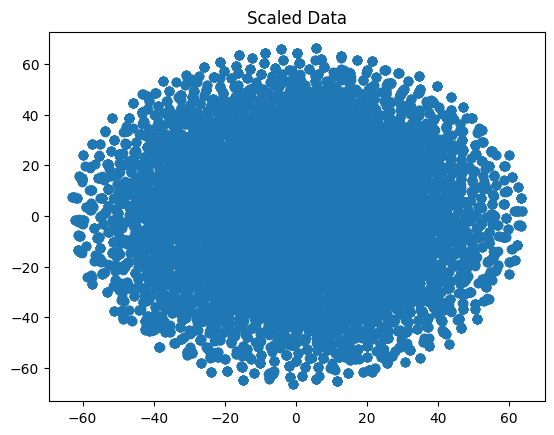

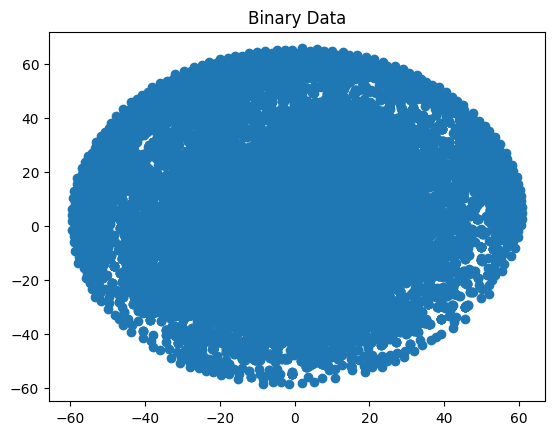

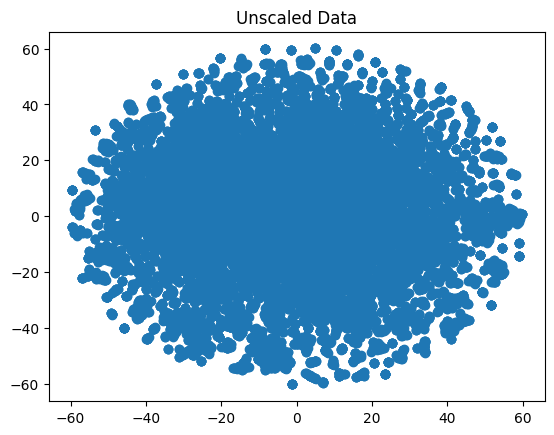

In [14]:
# It's rather visually obvious that the scaled and binary data are overfitting
plt.scatter(X_transform_scaled[:, 0], X_transform_scaled[:, 1])
plt.title("Scaled Data")
plt.show()

plt.scatter(X_transform_binary[:, 0], X_transform_binary[:, 1])
plt.title("Binary Data")
plt.show()

plt.scatter(X_transform[:, 0], X_transform[:, 1])
plt.title("Unscaled Data")
plt.show()

## Utilizing the Model
This is a simple usage of the model, where a user can search through the `DataFrame` and evaluate the recommendations. The `search_recommendations` function uses the unscaled data, but the `search` function can be used with any of the models.

In [15]:
"""
CHATGPT QUERY (used for line 9):
how would you make it so all of an arbitrary number of contain statements need to be satisfied
"""
# More versatile search function
def search(df, query, col_name='Recipe'):
    full_query_match = df[col_name].str.contains(query)
    if np.sum(full_query_match) > 0: return df[full_query_match]
    match_list = query.split(' ')
    masks = [df[col_name].str.contains(match) for match in match_list]
    total_mask = masks[0]
    for mask in masks[1:]:
        total_mask &= mask
    return neighbors_df[total_mask]

# Easier to use search function
def search_recommendations(query):
    pretty_print_titled_df(search(neighbors_df, query), f"Sample Search in Unscaled Data, Search Term: '{query}'")

In [16]:
search_recommendations('Chocolate Chip Peanut Butter Cookies')

,Recipe,KNN 1,KNN 2,KNN 3,KNN 4,KNN 5,KNN 6,KNN 7,KNN 8,KNN 9
3109,Peanut Butter Chocolate Chip Cookies from Heaven,Chocolate and Almond Biscotti,Moon Rocks,Chocolate Chews,Chocolate Peanut Butter Bars I,Mellow Chocolate Chip Cookies,Protein Peanut Butter Chocolate Chip Cookies,Marble Squares I,Best Ever Chocolate Chip Cookies II,The Perfect Chocolate Chip Cookie
3275,Chewy Peanut Butter Chocolate Chip Cookies,Robin's Nests,Best Ever Chewy Chocolate Chocolate Chunk Cookies,Chocolate X and O Cookies,Humungous Cookies,Chunks,Butterscotch Potato Chip Cookies,Potato Chip Cookies VI,Peanut Blossoms II,Cherry Chip Cookies II
3943,Peanut Butter Chocolate Chip Cookies II,Sunflower Drop Cookies,Mango Chutney,Peanut Butter Pie VIII,Key Lime Pie VI,Grill Dough,Pumpkin Bars II,Cappuccino-Kissed Cheesecake,Cranberry Cream Pie II,Apple Butter IV
3944,Chewy Chocolate Peanut Butter Chip Cookies,Peanut Butter Chip Chocolate Cookies,Chocolate Peanut Butter Pudding Cookies,Chocolate Peanut Butter Chip Cookies,Old Fashioned Peanut Butter Cookies,Candi's Chocolate Peanut Butter Chip Cookies,All That's Good Cookies,Peanut Butter Chip Cookies I,Peanut Butter and Chocolate Peanut Butter Cup Cookies,Doubly Delicious Peanut Butter Cookies
8404,Oatmeal Peanut Butter and Chocolate Chip Cookies,Cowboy Cookies III,Kitchen Sink Cookies,Monster Cookies IV,Spring Cleaning Cookies,LauHilLau Cookies,Lori's Awesome Cookies,Corn Flake Cookies II,Peanut Butter Bars VII,Cracker Jack Cookies II
8407,Peanut Butter Chip Chocolate Cookies,Chewy Chocolate Peanut Butter Chip Cookies,Chocolate Peanut Butter Pudding Cookies,Chocolate Peanut Butter Chip Cookies,Old Fashioned Peanut Butter Cookies,Candi's Chocolate Peanut Butter Chip Cookies,All That's Good Cookies,Peanut Butter and Chocolate Peanut Butter Cup Cookies,Peanut Butter Chip Cookies I,Doubly Delicious Peanut Butter Cookies
14415,Chocolate Peanut Butter Chip Cookies,Old Fashioned Peanut Butter Cookies,Chocolate Peanut Butter Pudding Cookies,Peanut Butter Chip Chocolate Cookies,Chewy Chocolate Peanut Butter Chip Cookies,All That's Good Cookies,Peanut Butter and Chocolate Peanut Butter Cup Cookies,Candi's Chocolate Peanut Butter Chip Cookies,Peanut Butter Chip Cookies I,Doubly Delicious Peanut Butter Cookies
16373,Candi's Chocolate Peanut Butter Chip Cookies,Chewy Chocolate Peanut Butter Chip Cookies,Peanut Butter Chip Chocolate Cookies,Peanut Butter Chip Cookies I,Chocolate Peanut Butter Pudding Cookies,Chocolate Peanut Butter Chip Cookies,Old Fashioned Peanut Butter Cookies,Doubly Delicious Peanut Butter Cookies,All That's Good Cookies,Peanut Butter and Chocolate Peanut Butter Cup Cookies
16468,Peanut Butter Chocolate Chip Cookies III,Poinsettia Balls,Orange Cranberry Drops,Frost-Bites,Chocolate Lebkuchen,Cranberry Oatmeal Drops,Libby's® Pumpkin Orange Cookies,Cranberry Macadamia Bars,Orange Sponge Cake,Orange Blueberry Pie
17076,Protein Peanut Butter Chocolate Chip Cookies,Marble Squares I,Chocolate Chews,Mellow Chocolate Chip Cookies,The Perfect Chocolate Chip Cookie,Moon Rocks,Mel's Magnificent Chocolate Chip Cookies,Banana Banana Bread,Peanut Butter Chocolate Chip Cookies from Heaven,Sue's Two-Chocolate Chip Cookies


## Further Analysis and Next Steps
There is one issue with t-SNE, which is that it doesn't work for queries of unseen data. That is, in order to consider new data points, the whole model will need to be retrained, which wouldn't have been the case with only k-NN. This means that if a user inputs a recipe themselves and wants recommendations for that, we may need to retrain the whole model, which could take a few minutes (especially as we collect more data). That being said, we could simply train a second model with just k-NN (no t-SNE preprocessing) and use that model, which can take queries, for user-inputted recipes, at least until the next retraining (assuming the model is regularly and automatically retrained).

Another issue with this implementation is that we don't yet have a way to detect when two similarly named ingredients are actually the same ingredient. For example, "black pepper" and "freshly cracked black pepper" are treated as two separate ingredients, which should not be the case. This could either be solved with another machine-learning based preprocessing step or lots of manual labeling. This would be extremely beneficial, though, as it would improve the model in two ways, both by more accurately spotting common ingredients between recipes and by decreasing the dimensionality of the data before t-SNE is applied.

As mentioned before, although it may be difficult, implementing some standard unit (again, probably grams) would also improve the quality of the model and may also make scaling the data a better approach, since the columns themselves are more uniform.